# Train The Ripeness Detection Model

This training script is responsible for fine-tuning an MobileNet-v2 model on our ripeness dataset. This notebook is a modifed version of the notebook from this tutorial: https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/

In [1]:

import os
import keras
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import tensorflow as tf
from keras.layers.core import Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torch.utils.data import random_split

from modules.datasets import RipenessDataset, ClassificationEnsembleDataset, save_classification_dataset

## Dataset

First, we load the ripeness dataset and save it to the ripeness folder with an 70%/20%/10% train-val-test split.

In [3]:
ripeness_dataset_dir = os.path.join('..', 'dataset', 'ripeness')
train_dataset_dir = os.path.join(ripeness_dataset_dir, 'train')
val_dataset_dir = os.path.join(ripeness_dataset_dir, 'val')
test_dataset_dir = os.path.join(ripeness_dataset_dir, 'test')

os.makedirs(train_dataset_dir, exist_ok=True)
os.makedirs(val_dataset_dir, exist_ok=True)
os.makedirs(test_dataset_dir, exist_ok=True)

ensemble_ripeness_dir = os.path.join(ripeness_dataset_dir, 'ensemble')
os.makedirs(ensemble_ripeness_dir, exist_ok=True)

seed = 123

In [3]:
ripeness_dataset = RipenessDataset()
dataset_len = len(ripeness_dataset)

# Split the dataset into train, validation and test sets, making sure that the size of each split adds up to the size of the original dataset.
train_dataset, val_dataset, test_dataset = random_split(ripeness_dataset, [round(dataset_len * 0.7), round(dataset_len * 0.2), round(dataset_len - dataset_len * .9)])

ensemble_dataset = ClassificationEnsembleDataset(label_type='ripeness', seed=seed)

In [4]:
classnames = ['unripe', 'ripe']
save_classification_dataset(train_dataset, train_dataset_dir, classes=classnames)
save_classification_dataset(val_dataset, val_dataset_dir, classes=classnames)
save_classification_dataset(test_dataset, test_dataset_dir, classes=classnames)

save_classification_dataset(ensemble_dataset, ensemble_ripeness_dir, classes=classnames)

Saving dataset to ..\dataset\ripeness\test: 100%|██████████| 136/136 [00:04<00:00, 30.17it/s]


In [5]:
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_dir,
    class_names=classnames,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 952 files belonging to 2 classes.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dataset_dir,
    class_names=classnames,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 272 files belonging to 2 classes.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_dir,
    seed=seed,
    class_names=classnames,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 136 files belonging to 2 classes.


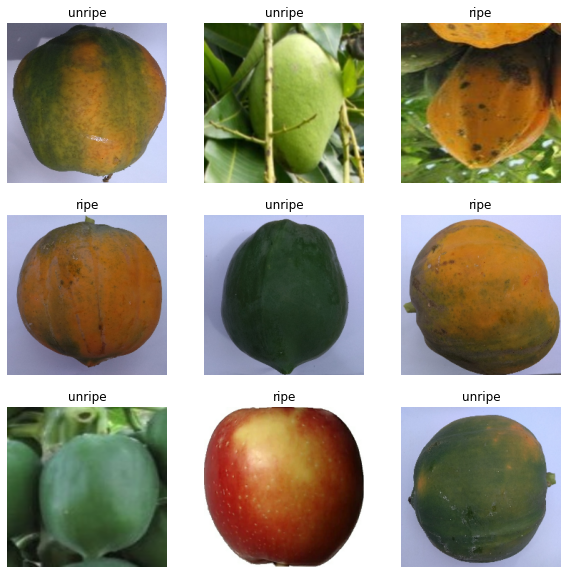

In [8]:

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classnames[labels[i]])
        plt.axis("off")


## Model

We use a pre-trained MobileNet-v2 model and fine-tune it on our ripeness dataset.

In [9]:
# Importing MobileNet-v2
mobilenet_v2_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=2,
    classifier_activation="softmax")


for layer in mobilenet_v2_model.layers:
        layer.trainable=False

In [10]:
# Importing pre trained model

ripeness_model = Sequential([
    mobilenet_v2_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

In [11]:
# Model Summary
ripeness_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
_________________________________________________________________


## Training



In [12]:
# Training

ripeness_model.compile(optimizer=Adam(learning_rate=0.002),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [13]:
epochs=8

history = ripeness_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
30/30 [==============================] - 8s 138ms/step - loss: 0.6756 - accuracy: 0.8015 - val_loss: 0.3032 - val_accuracy: 0.8603
Epoch 2/8
30/30 [==============================] - 4s 98ms/step - loss: 0.1989 - accuracy: 0.9244 - val_loss: 0.2220 - val_accuracy: 0.9154
Epoch 3/8
30/30 [==============================] - 4s 100ms/step - loss: 0.1492 - accuracy: 0.9401 - val_loss: 0.3347 - val_accuracy: 0.8640
Epoch 4/8
30/30 [==============================] - 4s 100ms/step - loss: 0.1234 - accuracy: 0.9475 - val_loss: 0.1686 - val_accuracy: 0.9338
Epoch 5/8
30/30 [==============================] - 4s 101ms/step - loss: 0.0837 - accuracy: 0.9695 - val_loss: 0.1661 - val_accuracy: 0.9265
Epoch 6/8
30/30 [==============================] - 4s 100ms/step - loss: 0.0653 - accuracy: 0.9811 - val_loss: 0.1531 - val_accuracy: 0.9301
Epoch 7/8
30/30 [==============================] - 4s 101ms/step - loss: 0.0782 - accuracy: 0.9685 - val_loss: 0.3626 - val_accuracy: 0.8824
Epoch 8/8
30/3

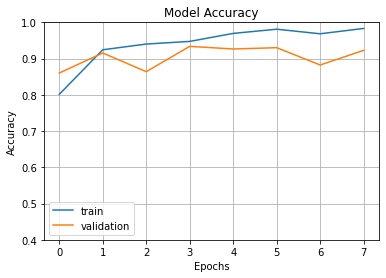

In [14]:
# Model Evaluation

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Now that the model is done training, we can save it. We save the model using a Keras SavedModel format. We need to copy the model to the weights folder before we can use it in DeepFruitVision.

In [15]:
# save the model
ripeness_model.save("ripeness_model")

INFO:tensorflow:Assets written to: ripeness_model\assets


INFO:tensorflow:Assets written to: ripeness_model\assets


## Evaluation

Now that we're done training the model, we can evaluate it on the test set, and we can create a confusion matrix to see how well the model performed.

In [16]:
ripeness_model.evaluate(test_ds)

5/5 [==============================] - 1s 78ms/step - loss: 0.1924 - accuracy: 0.9118


[0.19241651892662048, 0.9117646813392639]

In [17]:
predictions = []
labels = []
for x, y in test_ds:
    predicted_categories = np.argmax(ripeness_model.predict(x), axis = 1)
    predictions.append(predicted_categories)
    labels.append(y)


predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

print(predictions.shape)
print(labels.shape)
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

1/1 [==============================] - 1s 549ms/step
(136,)
(136,)


array([[71,  6],
       [ 6, 53]])

In [18]:
print(classification_report(labels, predictions, target_names=classnames))

              precision    recall  f1-score   support

      unripe       0.92      0.92      0.92        77
        ripe       0.90      0.90      0.90        59

    accuracy                           0.91       136
   macro avg       0.91      0.91      0.91       136
weighted avg       0.91      0.91      0.91       136



Now lets take a look at some of the model's predictions on the test set.

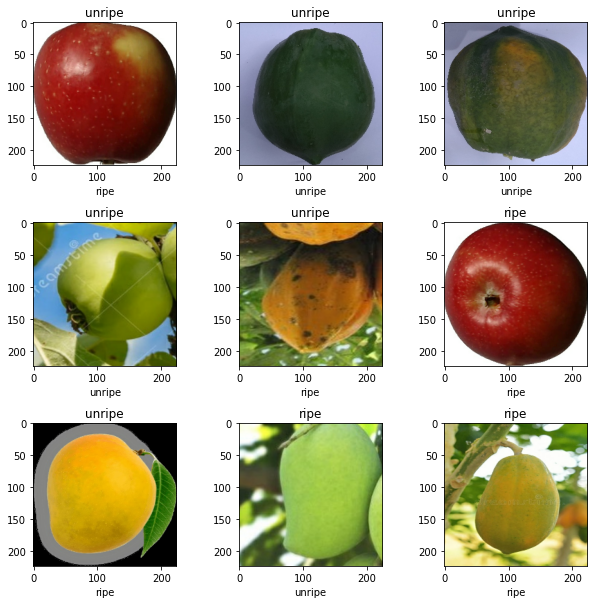

In [19]:
# Plotting some of the predictions using matplotlib

plt.figure(figsize=(10, 10))
# increase the space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[int(predictions[i])])
    # also print the true label
    plt.xlabel(classnames[labels[i]])
    #plt.axis("off")
plt.show()

Now that we are done with training and evaluation, we can clean up the ripeness dataset folder we created to save on disk space. This also lets us cleanly rerun the notebook without having to worry any dataset conflicts

In [20]:
import shutil

# Cleaning up the ripeness dataset folder
shutil.rmtree(ripeness_dataset_dir)